In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import glob
import datetime
from joblib import Parallel, delayed
from neuraltda import simpComp as sc
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

homedir = os.path.expanduser('~')
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = os.path.join(homedir, 'DailyLog/'+daystr+'/')
print(figsavepth)
plt.style.use(os.path.join(homedir, 'code/NeuralTDA/gentnerlab.mplstyle'))

/home/AD/btheilma/DailyLog/20190403/


In [6]:
def get_JS_spec(i, j, speci, specj, specm, beta):
    js = (i, j, sc.sparse_JS_divergence2_spec(speci, specj, specm, beta))
    return js

def compute_JS_div_mtx(lapspectra, Mspectra, beta):
    N = len(lapspectra)
    pairs = [(i, j) for i in range(N) for j in range(i, N)]
    #print('Computing JS Divergences with beta {}...'.format(beta))
    jsmat = np.zeros((N, N))
    jsdat = Parallel(n_jobs=24)(delayed(get_JS_spec)(i, j, lapspectra[i], lapspectra[j], Mspectra[(i,j)], beta) for (i, j) in pairs)
    for d in jsdat:
        jsmat[d[0], d[1]] = d[2]
    
    return jsmat

def compute_within_vs_between(mtx, ntrials, nstim, diag=0):
    stim_per_group = int(nstim//2)
    
    btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
    within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials, diag)]
    within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials, diag)]
    
    within = np.concatenate((within1, within2))
    return (btwn_data, within)

def get_lapfile_params(lapfile):
    lap_filename = os.path.splitext(os.path.split(lapfile)[-1])[0]
    params = lap_filename.split('Lapsectra_')[-1].split('-')
    fam = params[-1]
    shuf = params[-2]
    ntrials = params[-3]
    bird = params[-4]
    return {'bird': bird, 'ntrials': ntrials, 'shuf': shuf, 'fam': fam}

def compute_withins_vs_between(mtx, ntrials, nstim, diag=0):
    stim_per_group = int(nstim//2)
    
    btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
    within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials, diag)]
    within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials, diag)]
    
    within = np.concatenate((within1, within2))
    return (btwn_data, within1, within2)

In [7]:
betas = np.logspace(-1, 2)
nstim = 4
ntrials=20

lap_path = os.path.join(homedir, 'laplacians/Lapspectra*.pkl')
m_path = os.path.join(homedir, 'laplacians/Mspectra*.pkl')


lap_files = glob.glob(lap_path)
m_files = glob.glob(m_path)

file_pairs = []
for lap_file in lap_files:
    lap_filename = os.path.split(lap_file)[-1]
    params = lap_filename.split('Lapspectra')[-1]
    m_files = glob.glob(os.path.join(homedir, 'laplacians/'+'Mspectra'+params))
    if m_files:
        file_pairs.append((lap_file, m_files[0]))

file_pairs = sorted(file_pairs)
print(file_pairs)

[('/home/AD/btheilma/laplacians/Lapspectra_B1056-20-original-familiar.pkl', '/home/AD/btheilma/laplacians/Mspectra_B1056-20-original-familiar.pkl'), ('/home/AD/btheilma/laplacians/Lapspectra_B1056-20-original-unfamiliar.pkl', '/home/AD/btheilma/laplacians/Mspectra_B1056-20-original-unfamiliar.pkl'), ('/home/AD/btheilma/laplacians/Lapspectra_B1056-20-shuffled-familiar.pkl', '/home/AD/btheilma/laplacians/Mspectra_B1056-20-shuffled-familiar.pkl'), ('/home/AD/btheilma/laplacians/Lapspectra_B1056-20-shuffled-unfamiliar.pkl', '/home/AD/btheilma/laplacians/Mspectra_B1056-20-shuffled-unfamiliar.pkl'), ('/home/AD/btheilma/laplacians/Lapspectra_B1083-20-original-familiar.pkl', '/home/AD/btheilma/laplacians/Mspectra_B1083-20-original-familiar.pkl'), ('/home/AD/btheilma/laplacians/Lapspectra_B1083-20-original-unfamiliar.pkl', '/home/AD/btheilma/laplacians/Mspectra_B1083-20-original-unfamiliar.pkl'), ('/home/AD/btheilma/laplacians/Lapspectra_B1083-20-shuffled-familiar.pkl', '/home/AD/btheilma/lapla

/home/AD/btheilma/anaconda3/envs/neuraltda-4/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


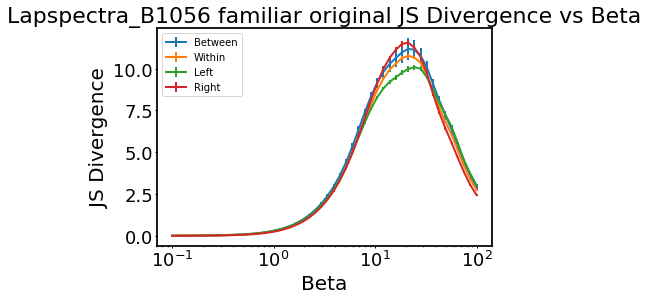

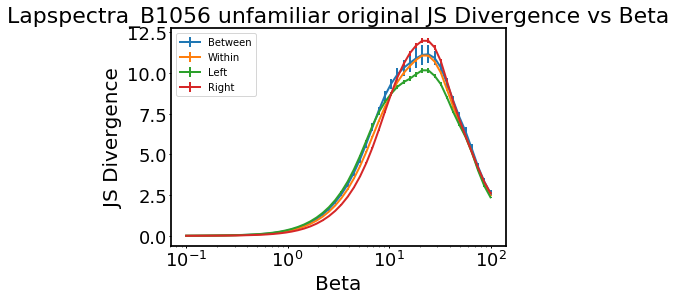

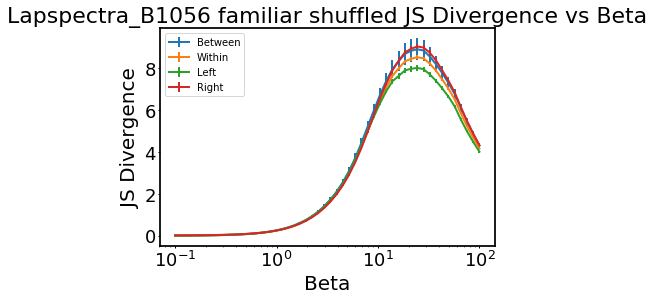

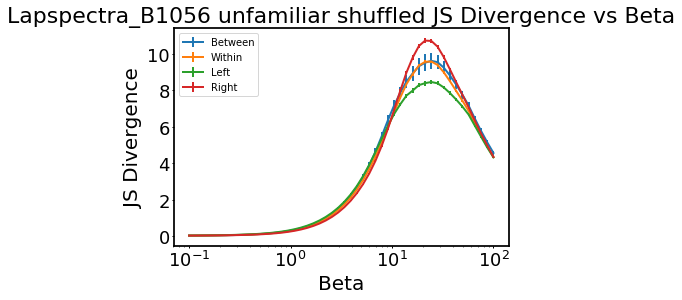

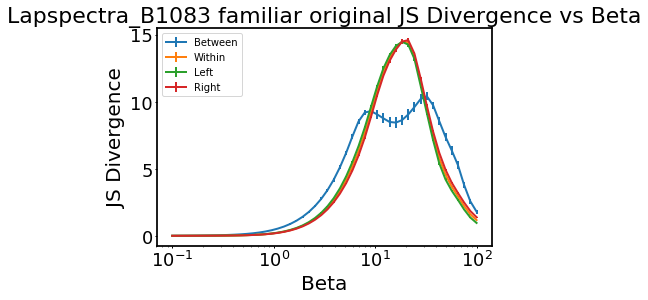

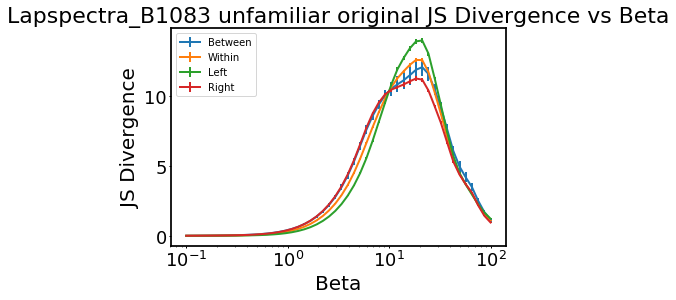

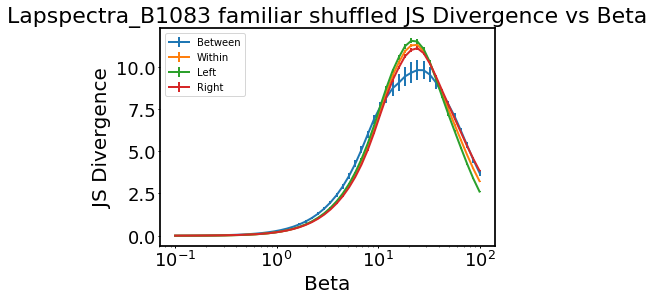

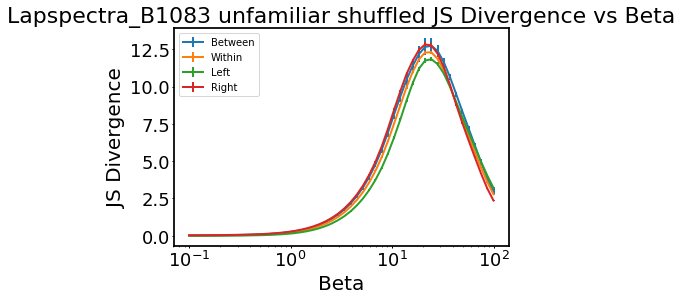

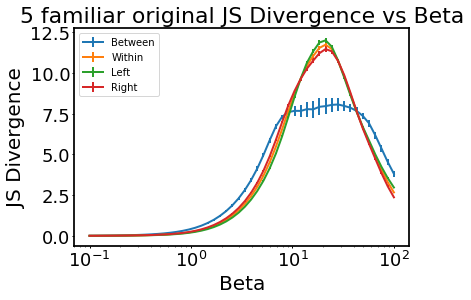

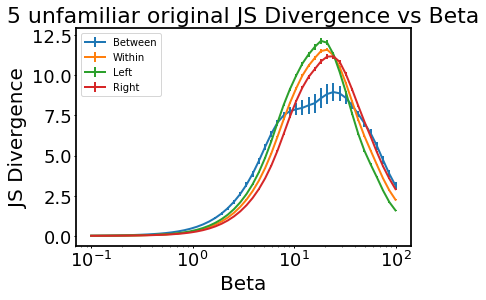

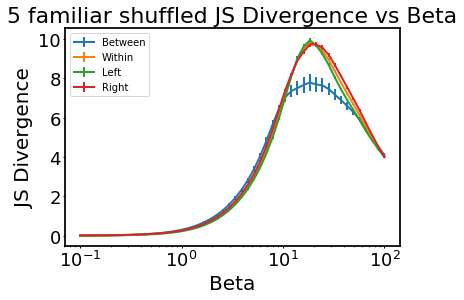

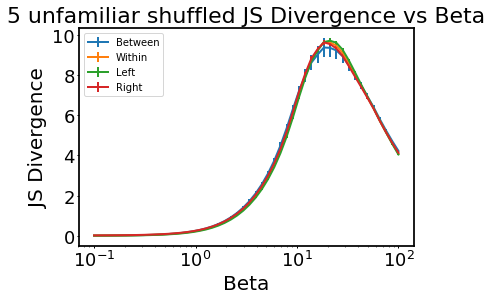

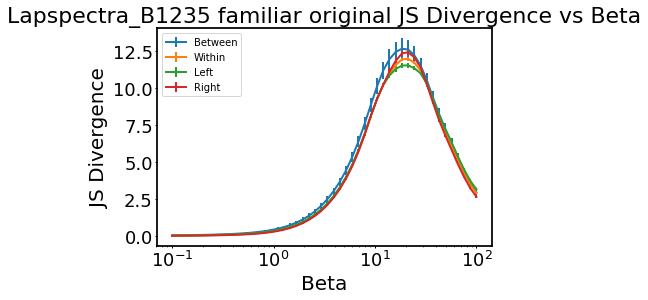

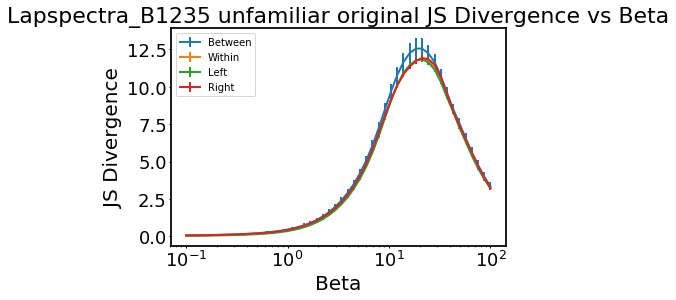

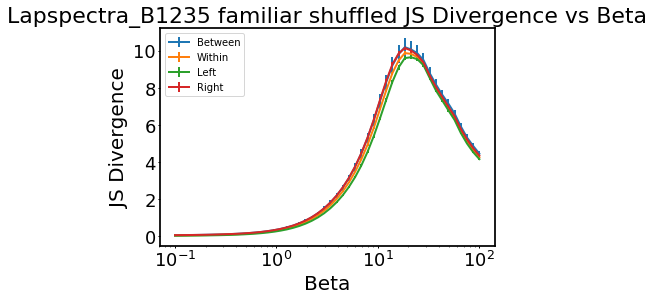

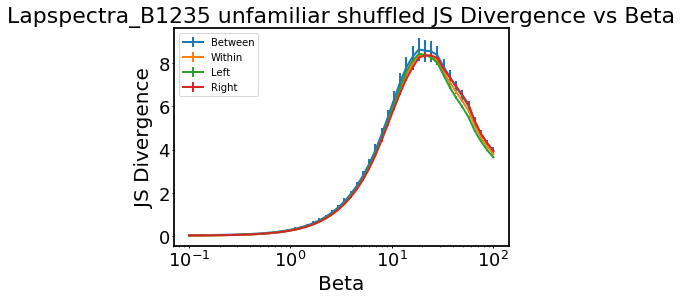

In [4]:
for indf, pair in enumerate(tqdm(file_pairs)):
    lap_file, m_file = pair
    
    params = get_lapfile_params(lap_file)
    with open(lap_file, 'rb') as f:
        lapspectra = pickle.load(f)
    with open(m_file, 'rb') as f:
        Mspectra = pickle.load(f)
    btwn_means = np.zeros(len(betas))
    btwn_stds = np.zeros(len(betas))
    wthn_means = np.zeros(len(betas))
    wthn_stds = np.zeros(len(betas))
    wthn1_means = np.zeros(len(betas))
    wthn1_stds = np.zeros(len(betas))
    wthn2_means = np.zeros(len(betas))
    wthn2_stds = np.zeros(len(betas))

    for ind, beta in enumerate(tqdm(betas)):
        mat = compute_JS_div_mtx(lapspectra, Mspectra, beta)
        (btwn, wthn1, wthn2) = compute_withins_vs_between(mat, ntrials, nstim, diag=0)
    #     btwn = np.sqrt(btwn)
    #     wthn1 = np.sqrt(wthn1)
    #     wthn2 = np.sqrt(wthn2)
        wthn = np.concatenate((wthn1, wthn2))
        btwn_means[ind] = np.mean(btwn)
        btwn_stds[ind] = np.std(btwn) / np.sqrt(len(btwn))
        wthn_means[ind] = np.mean(wthn)
        wthn_stds[ind] = np.std(wthn) / np.sqrt(len(wthn))
        wthn1_means[ind] = np.mean(wthn1)
        wthn1_stds[ind] = np.std(wthn1) / np.sqrt(len(wthn1))
        wthn2_means[ind] = np.mean(wthn2)
        wthn2_stds[ind] = np.std(wthn2) / np.sqrt(len(wthn2))
    plt.figure()
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    plt.errorbar(betas, btwn_means, yerr=btwn_stds)
    plt.errorbar(betas, wthn_means, yerr=wthn_stds)
    plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
    plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
    plt.title('{} {} {} JS Divergence vs Beta'.format(params['bird'], params['fam'], params['shuf']))
    plt.xlabel('Beta')
    plt.ylabel('JS Divergence')
    plt.legend(['Between', 'Within', 'Left', 'Right'])
    plt.savefig(os.path.join(figsavepth, '{}-{}-{}-JSDivVsBeta.pdf'.format(params['bird'], params['fam'], params['shuf'])))

/home/AD/btheilma/anaconda3/envs/neuraltda-4/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


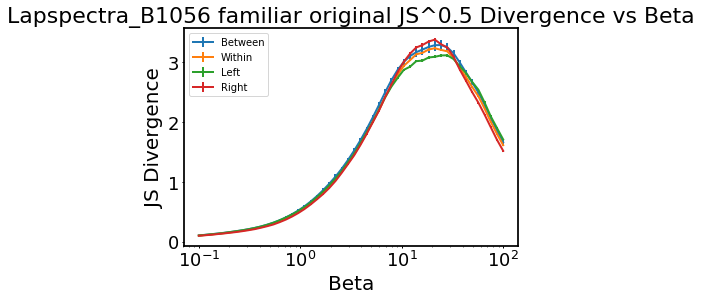

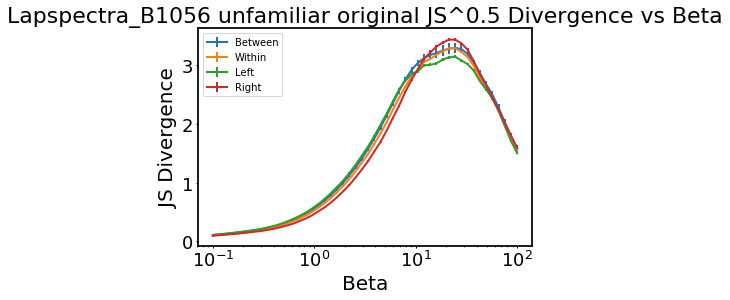

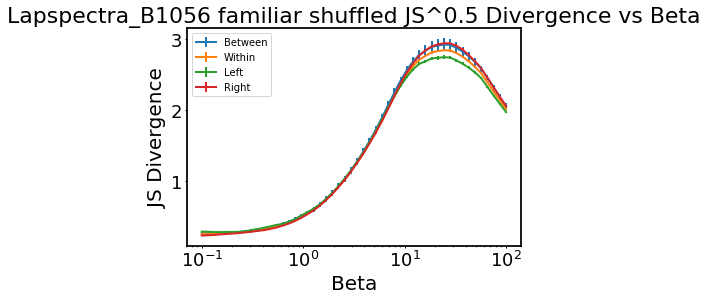

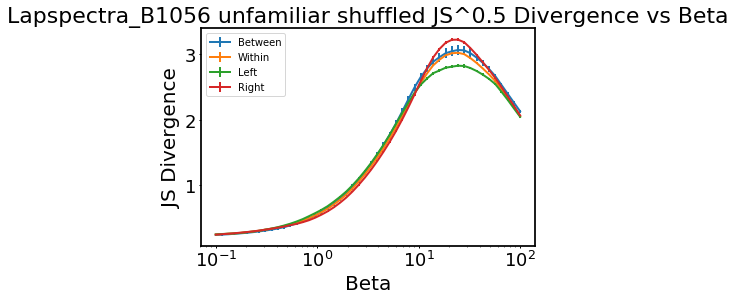

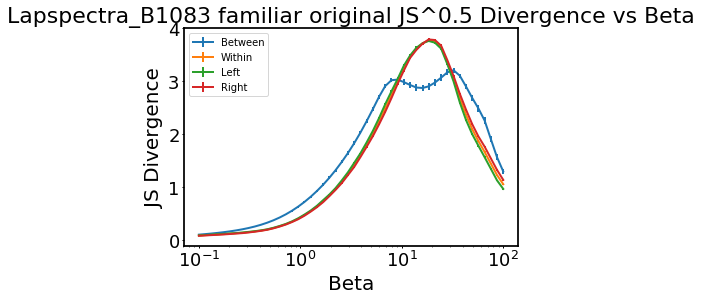

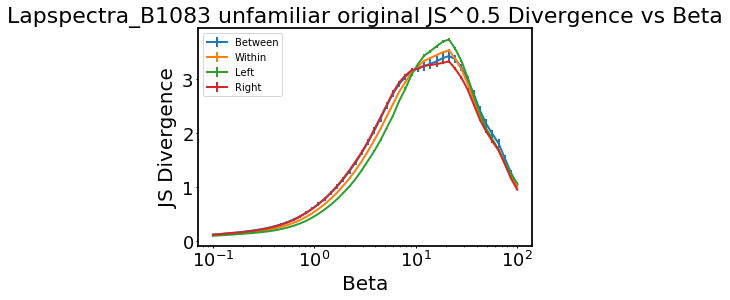

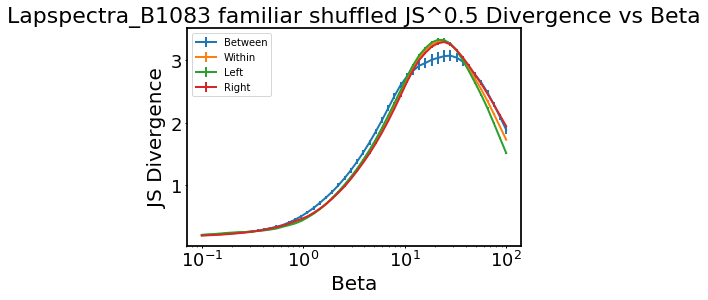

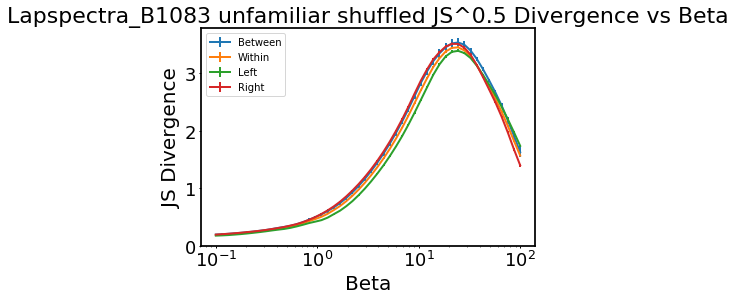

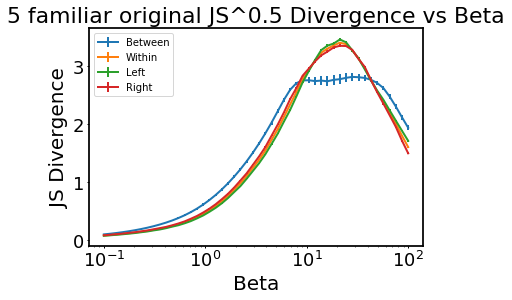

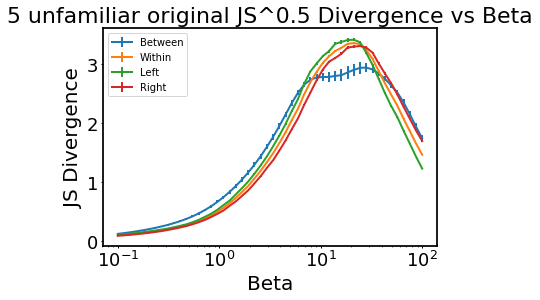

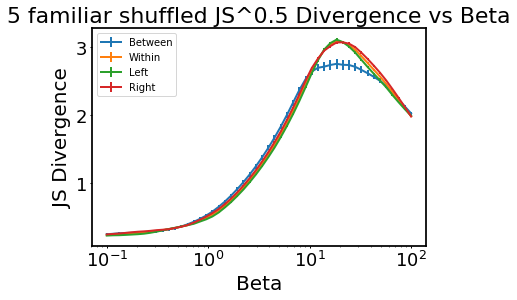

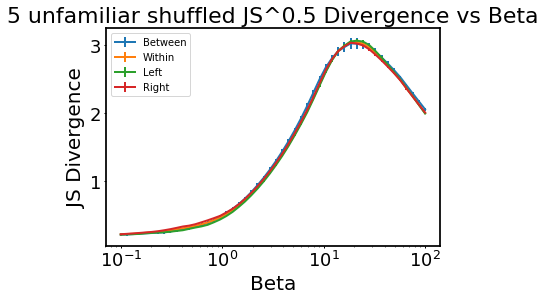

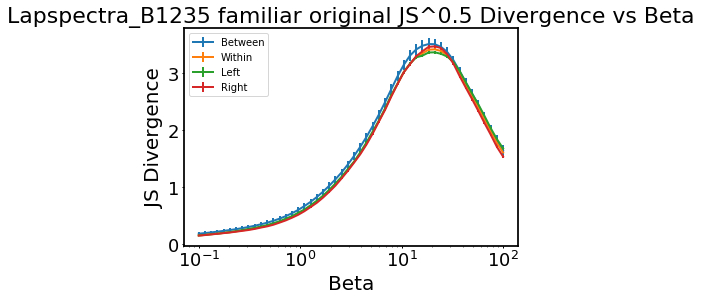

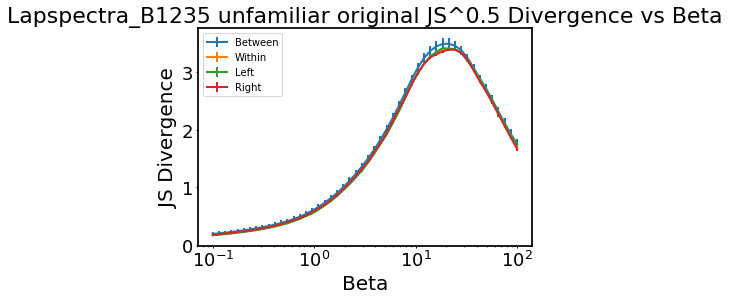

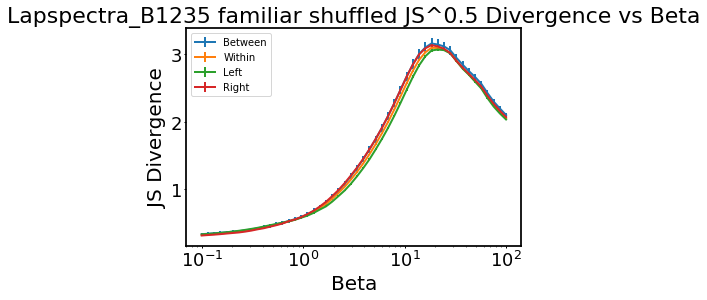

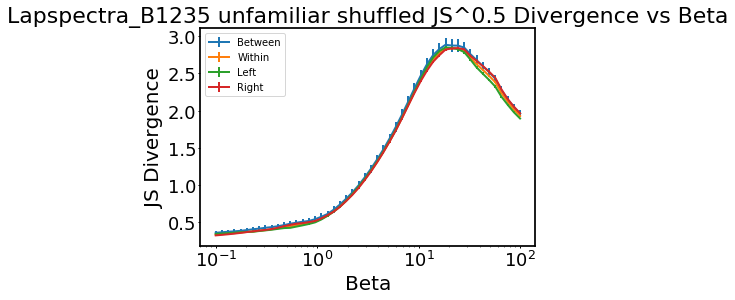

In [17]:
# Sqrt JS
betas = np.logspace(-1, 2, 50)
divs = {}
for indf, pair in enumerate(tqdm(file_pairs)):
    lap_file, m_file = pair
    
    params = get_lapfile_params(lap_file)
    with open(lap_file, 'rb') as f:
        lapspectra = pickle.load(f)
    with open(m_file, 'rb') as f:
        Mspectra = pickle.load(f)
    btwn_means = np.zeros(len(betas))
    btwn_stds = np.zeros(len(betas))
    wthn_means = np.zeros(len(betas))
    wthn_stds = np.zeros(len(betas))
    wthn1_means = np.zeros(len(betas))
    wthn1_stds = np.zeros(len(betas))
    wthn2_means = np.zeros(len(betas))
    wthn2_stds = np.zeros(len(betas))

    for ind, beta in enumerate(tqdm(betas)):
        mat = np.sqrt(compute_JS_div_mtx(lapspectra, Mspectra, beta))
        (btwn, wthn1, wthn2) = compute_withins_vs_between(mat, ntrials, nstim, diag=0)
    #     btwn = np.sqrt(btwn)
    #     wthn1 = np.sqrt(wthn1)
    #     wthn2 = np.sqrt(wthn2)
        wthn = np.concatenate((wthn1, wthn2))
        btwn_means[ind] = np.nanmean(btwn)
        btwn_stds[ind] = np.nanstd(btwn) / np.sqrt(len(btwn))
        wthn_means[ind] = np.nanmean(wthn)
        wthn_stds[ind] = np.nanstd(wthn) / np.sqrt(len(wthn))
        wthn1_means[ind] = np.nanmean(wthn1)
        wthn1_stds[ind] = np.nanstd(wthn1) / np.sqrt(len(wthn1))
        wthn2_means[ind] = np.nanmean(wthn2)
        wthn2_stds[ind] = np.nanstd(wthn2) / np.sqrt(len(wthn2))
        
    divs[(params['bird'], params['fam'], params['shuf'])] =  (btwn_means, btwn_stds, wthn_means, wthn_stds, wthn1_means, wthn1_stds, wthn2_means, wthn2_stds)
    
    plt.figure()
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    plt.errorbar(betas, btwn_means, yerr=btwn_stds)
    plt.errorbar(betas, wthn_means, yerr=wthn_stds)
    plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
    plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
    plt.title('{} {} {} JS^0.5 Divergence vs Beta'.format(params['bird'], params['fam'], params['shuf']))
    plt.xlabel('Beta')
    plt.ylabel('JS Divergence')
    plt.legend(['Between', 'Within', 'Left', 'Right'])
    plt.savefig(os.path.join(figsavepth, '{}-{}-{}-SqrtJSDivVsBeta.pdf'.format(params['bird'], params['fam'], params['shuf'])))

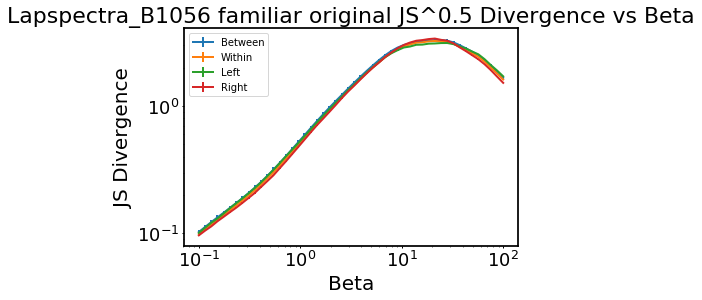

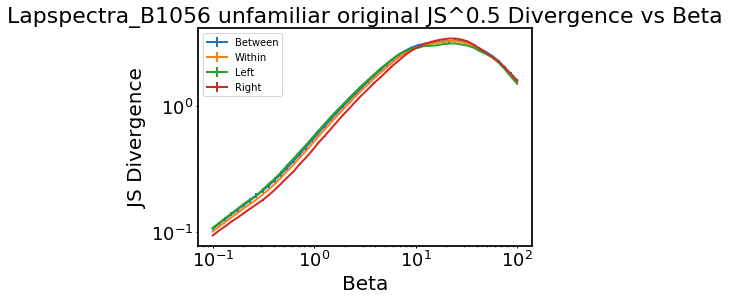

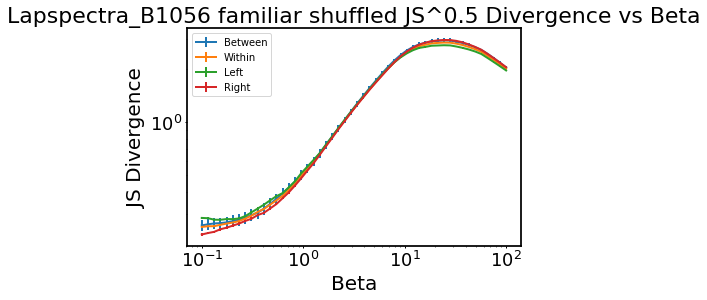

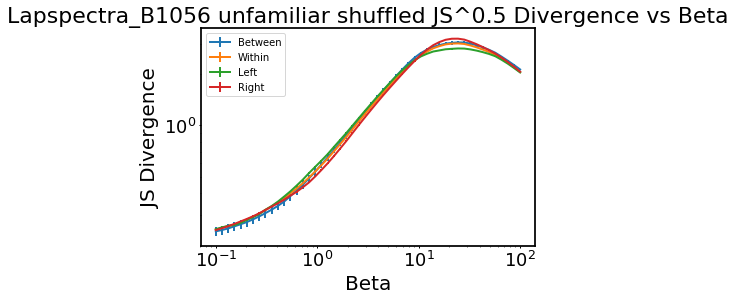

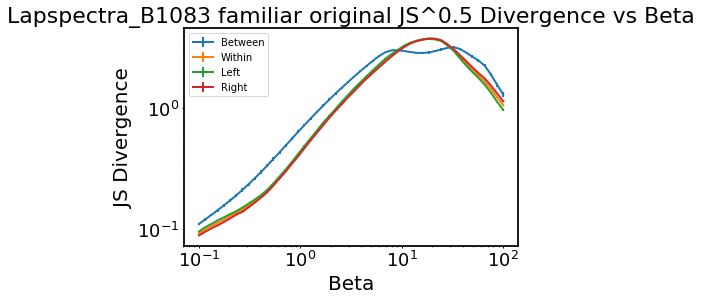

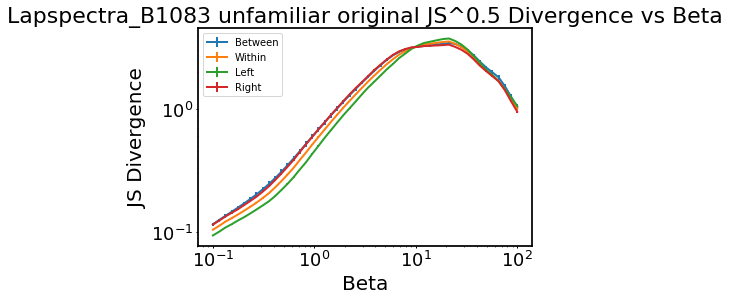

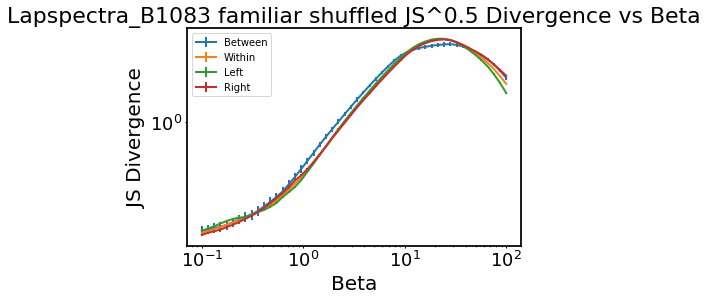

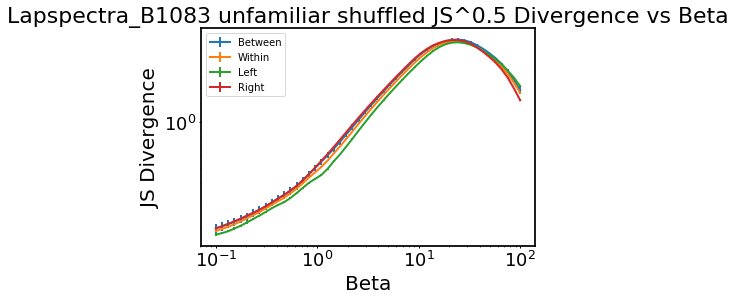

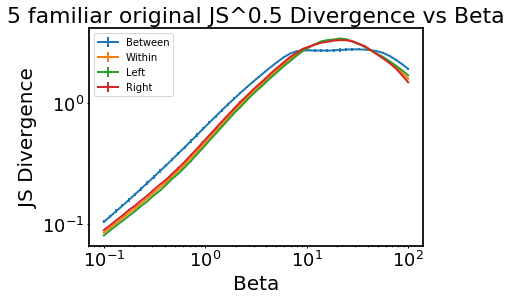

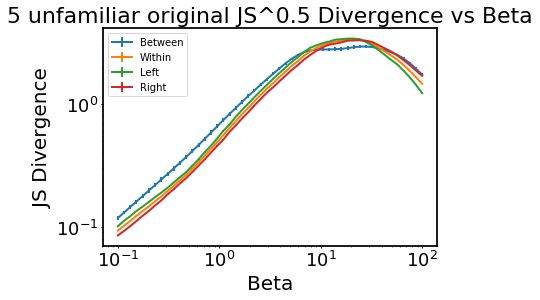

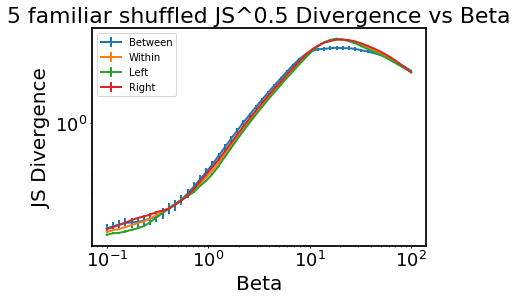

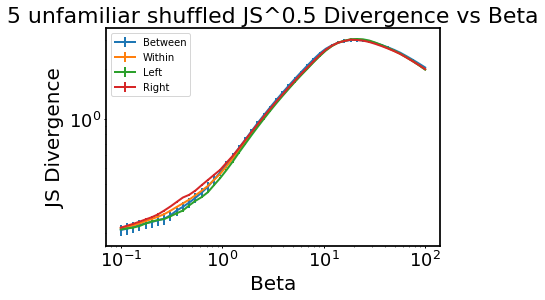

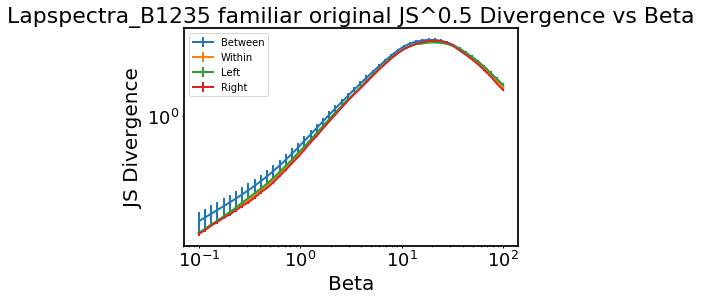

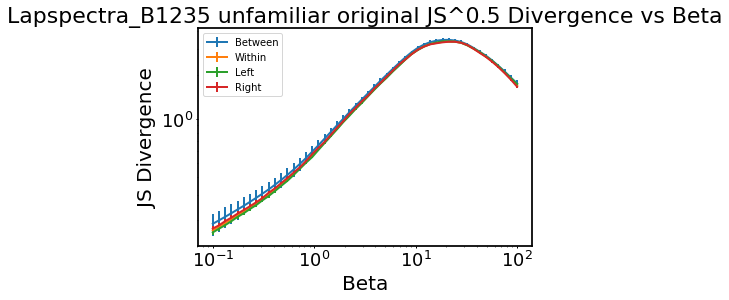

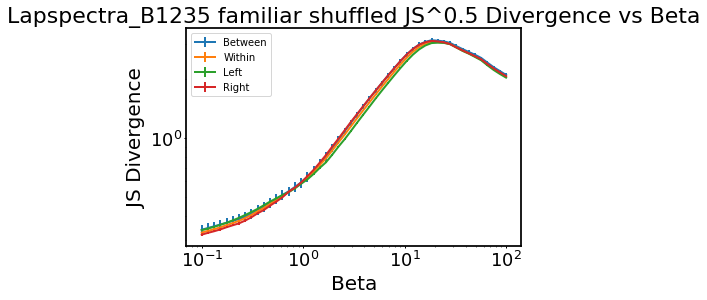

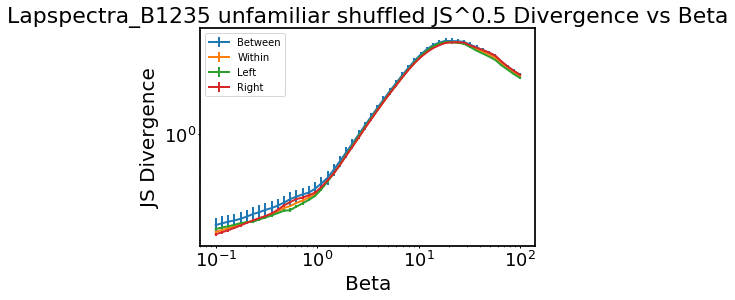

In [19]:
for k in divs.keys():
    (btwn_means, btwn_stds, wthn_means, wthn_stds, wthn1_means, wthn1_stds, wthn2_means, wthn2_stds) = divs[k]
    bird = k[0]
    fam = k[1]
    shuf = k[2]
    plt.figure()
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    ax.set_yscale("log", nonposy='clip')
    plt.errorbar(betas, btwn_means, yerr=btwn_stds)
    plt.errorbar(betas, wthn_means, yerr=wthn_stds)
    plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
    plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
    plt.title('{} {} {} JS^0.5 Divergence vs Beta'.format(bird, fam, shuf))
    plt.xlabel('Beta')
    plt.ylabel('JS Divergence')
    plt.legend(['Between', 'Within', 'Left', 'Right'])
    #plt.savefig(os.path.join(figsavepth, '{}-{}-{}-JSDivVsBeta.pdf'.format(bird, fam, shuf))

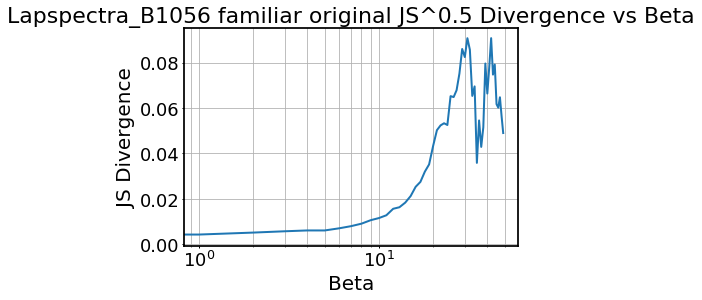

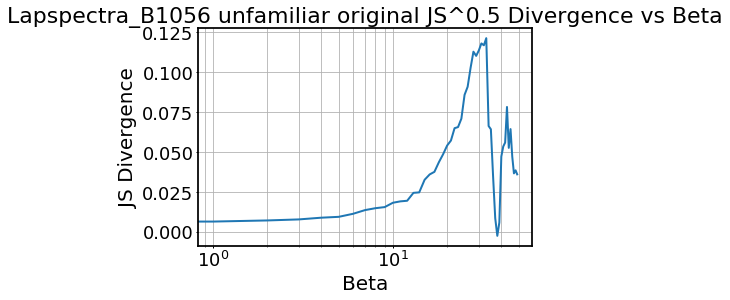

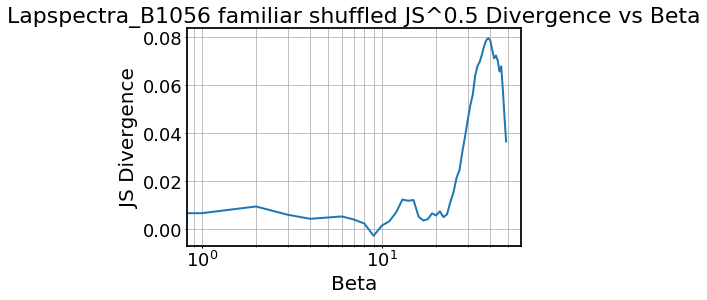

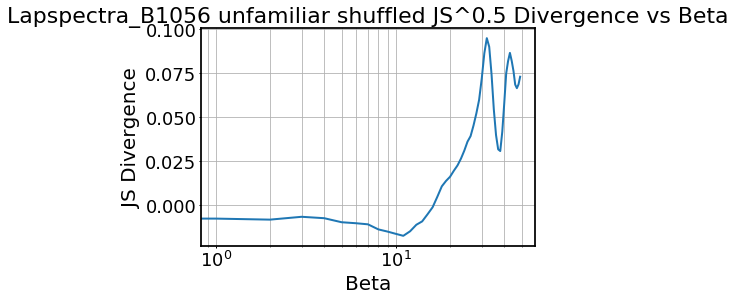

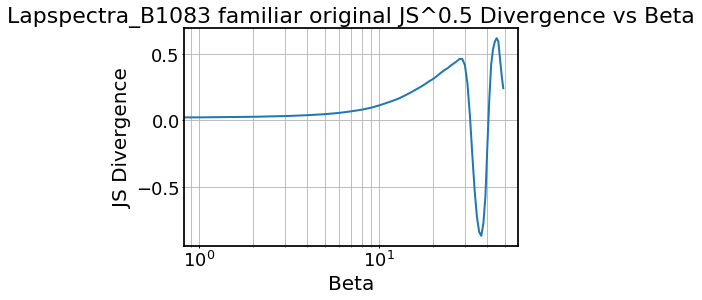

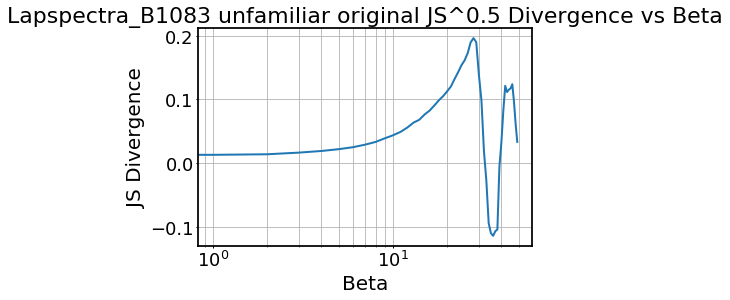

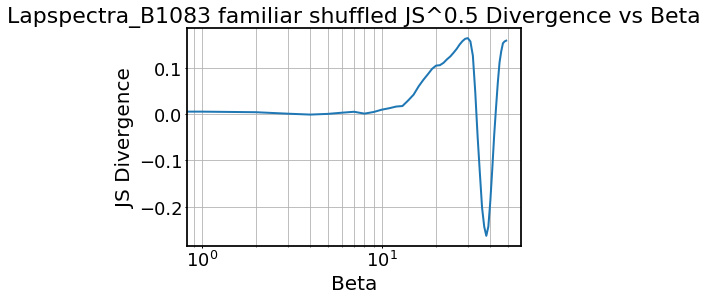

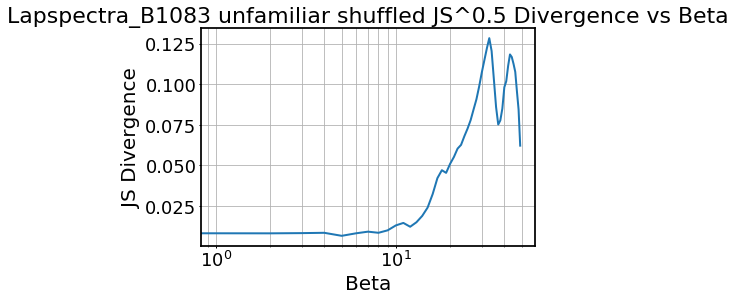

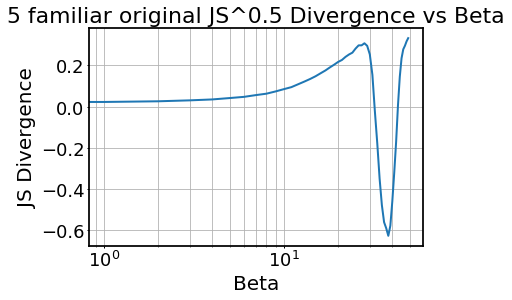

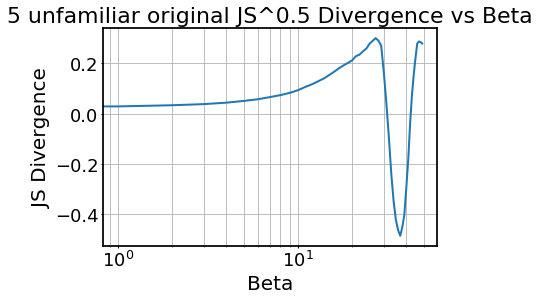

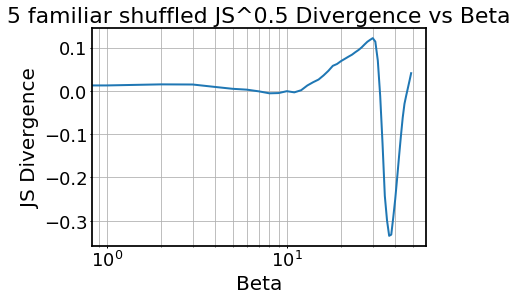

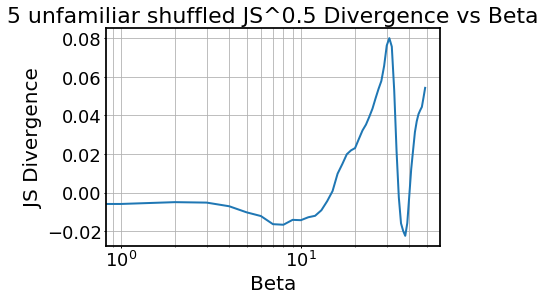

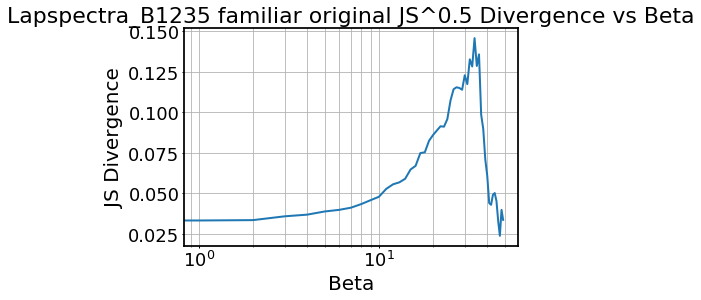

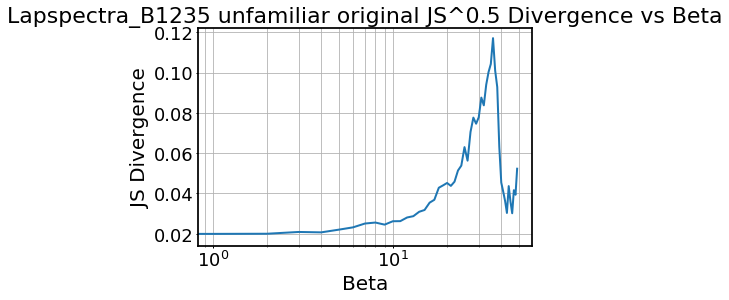

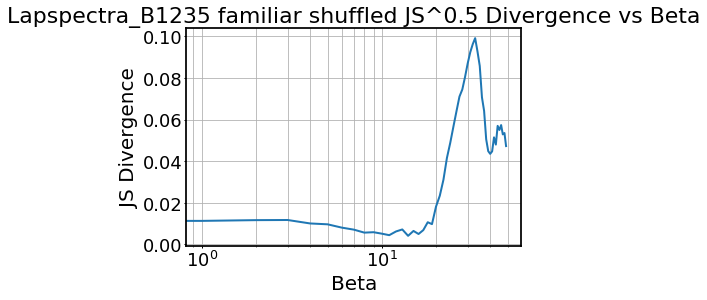

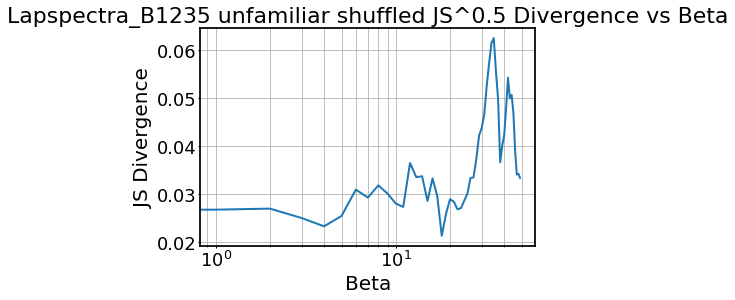

In [21]:
for k in divs.keys():
    (btwn_means, btwn_stds, wthn_means, wthn_stds, wthn1_means, wthn1_stds, wthn2_means, wthn2_stds) = divs[k]
    bird = k[0]
    fam = k[1]
    shuf = k[2]
    plt.figure()
    plt.semilogx(btwn_means - wthn_means)
    plt.grid(which='both')
#     ax = plt.subplot(111)
#     ax.set_xscale("log", nonposx='clip')
#     #ax.set_yscale("log", nonposy='clip')
#     plt.errorbar(betas, btwn_means, yerr=btwn_stds)
#     plt.errorbar(betas, wthn_means, yerr=wthn_stds)
#     plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
#     plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
    plt.title('{} {} {} JS^0.5 Divergence vs Beta'.format(bird, fam, shuf))
    plt.xlabel('Beta')
    plt.ylabel('JS Divergence')
#     plt.legend(['Between', 'Within', 'Left', 'Right'])
    #plt.savefig(os.path.join(figsavepth, '{}-{}-{}-JSDivVsBeta.pdf'.format(bird, fam, shuf))

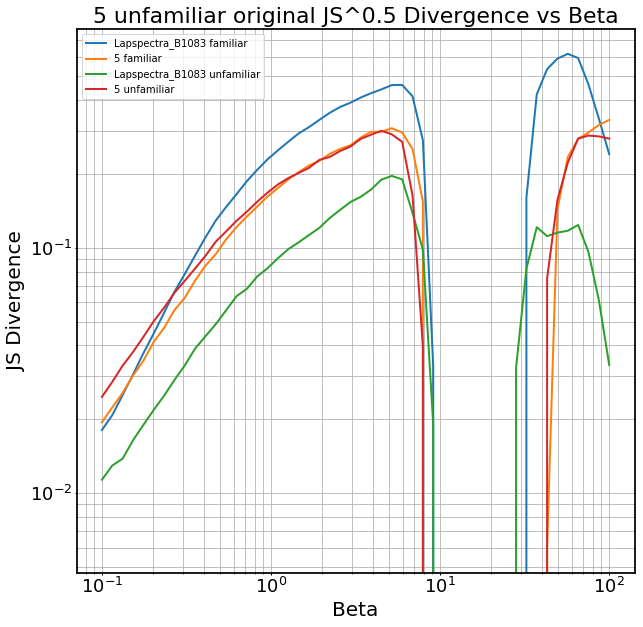

In [32]:
 plt.figure(figsize=(10, 10))
for k in [('Lapspectra_B1083', 'familiar', 'original'), ('5', 'familiar', 'original'),
          ('Lapspectra_B1083', 'unfamiliar', 'original'), ('5', 'unfamiliar', 'original')]:
    (btwn_means, btwn_stds, wthn_means, wthn_stds, wthn1_means, wthn1_stds, wthn2_means, wthn2_stds) = divs[k]
    bird = k[0]
    fam = k[1]
    shuf = k[2]
   
    plt.loglog(betas, btwn_means - wthn_means, label=bird + ' ' + fam)
plt.grid(which='both')
#     ax = plt.subplot(111)
#     ax.set_xscale("log", nonposx='clip')
#     #ax.set_yscale("log", nonposy='clip')
#     plt.errorbar(betas, btwn_means, yerr=btwn_stds)
#     plt.errorbar(betas, wthn_means, yerr=wthn_stds)
#     plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
#     plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
plt.title('{} {} {} JS^0.5 Divergence vs Beta'.format(bird, fam, shuf))
plt.xlabel('Beta')
plt.ylabel('JS Divergence')
plt.legend()
#plt.savefig(os.path.join(figsavepth, '{}-{}-{}-JSDivVsBeta.pdf'.format(bird, fam, shuf))

Text(0,0.5,'JS Divergence')

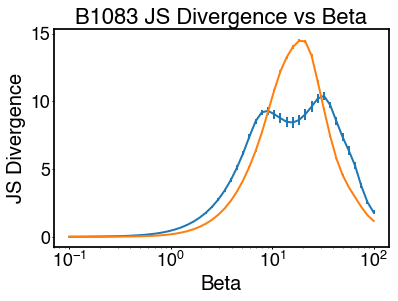

In [6]:
ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
plt.errorbar(betas, btwn_means, yerr=btwn_stds)
plt.errorbar(betas, wthn_means, yerr=wthn_stds)
plt.title('B1083 JS Divergence vs Beta')
plt.xlabel('Beta')
plt.ylabel('JS Divergence')